# Network Web Analysis in English Articles

## 1. Module Import

In [1]:
# self defined Modules
from myModules.utils.data.DataLoader import DataLoader
from myModules.utils.merge.mergeOverPeriod import merge
from myModules.preprocess import cleaning, removeStopWords_ST, tokenizing_ST

# General Modules
import pandas as pd
import numpy as np
import warnings
from tqdm.notebook import tqdm
import operator

warnings.filterwarnings('ignore')

# Read File
import glob

# NLP
import nltk
from nltk.tokenize import TreebankWordTokenizer

# Visualization
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
%matplotlib inline

## 2. Data Load

In [2]:
DATA_ROOT = './Data/3구간/'

PERIOD_1 = DATA_ROOT + '1시기/1시기_ST/'
PERIOD_2 = DATA_ROOT + '2시기/2시기_ST/'
PERIOD_3 = DATA_ROOT + '3시기/3시기_ST/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/ST/'
RESULT_2 = RESULT_ROOT + '/2시기/ST/'
RESULT_3 = RESULT_ROOT + '/3시기/ST/'

In [ ]:
files_1 = glob.glob(PERIOD_1+'*.txt')
files_2 = glob.glob(PERIOD_2+'*.txt')
files_3 = glob.glob(PERIOD_3+'*.txt')

texts_1 = DataLoader(files_1, mode='ST')
texts_2 = DataLoader(files_2, mode='ST')
texts_3 = DataLoader(files_3, mode='ST')

## 3. PreProcess

### 3-1. Data Cleaning

In [ ]:
cleaned_1 = cleaning(texts_1, mode='ST')
cleaned_2 = cleaning(texts_2, mode='ST')
cleaned_3 = cleaning(texts_3, mode='ST')

### 3-2. Tokenizing

In [ ]:
tokenizer = TreebankWordTokenizer()

tokenized_1 = tokenizing_ST(cleaned_1, tokenizer)
tokenized_2 = tokenizing_ST(cleaned_2, tokenizer)
tokenized_3 = tokenizing_ST(cleaned_3, tokenizer)

### 3-3. Remove Stopwords

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['would', 'could', 'might', 'need', 'can', 'must', \
    'e', 'one', 'two', 'upon', 'may', 'perhaps', 'living', 'seem', 'also', 'ii', 'ofthe',
    'also', 'much', 'therefore']

wo_stopword_1 = removeStopWords_ST(tokenized_1, stopwords, new_stopwords)
wo_stopword_2 = removeStopWords_ST(tokenized_2, stopwords, new_stopwords)
wo_stopword_3 = removeStopWords_ST(tokenized_3, stopwords, new_stopwords)

## 4. Network Web Analysis

1. (시도 1) apriori를 이용하여 Token간 연관성 계산
    - 연관성 계산에 너무 많은 시간이 걸림.
2. (시도 2) 직접 동시출현빈도를 계산


In [3]:
class vocaDict:
    def __init__(self):
        self.word2id = {}
        self.id2word = []
        self.count = {}
    
    def getIdOrAdd(self, word):
        if word in self.word2id:
            return self.word2id[word]
        self.word2id[word] = len(self.word2id)
        self.id2word.append(word)
        return len(self.word2id) - 1
    
    def getWord(self, id):
        return self.id2word[id]
    
    def calcWordPairFreq(self, text):
        wordIds = [self.getIdOrAdd(word) for word in text]
        for idx, a in enumerate(tqdm(wordIds, desc="Word Pair Frequency ")):
            for b in wordIds[idx+1:]:
                if a == b: continue
                if a > b: a, b = b, a
                self.count[a, b] = self.count.get((a, b), 0) + 1
        return self.count
    
    def to_csv(self, root='./'):
        df = []
        for key, val in self.count.items():
            df.append([self.getWord(key[0]), self.getWord(key[1]), val])
        df = pd.DataFrame(df, columns=['word1', 'word2', 'freq'])
        df = df.sort_values(by=['freq'], ascending=False)
        df = df.reset_index(drop=True)

        df.to_csv(root+'word-pair-freq.csv', index=False)

class Network:
    def calc_properties(self, edge_num, data):
        self.edge_num = edge_num
        self.data = data

        G_centrality = nx.Graph()

        for idx in range(self.edge_num):
            G_centrality.add_edge(self.data['word1'][idx], self.data['word2'][idx], weight=int(self.data['freq'][idx]))
        
        self.dgr = nx.degree_centrality(G_centrality)
        self.pgr = nx.pagerank(G_centrality)

        self.dgr = sorted(self.dgr.items(), key=operator.itemgetter(1), reverse=True)
        self.pgr = sorted(self.pgr.items(), key=operator.itemgetter(1), reverse=True)
    
    def plot(self, title='Network Web Analysis', root='./'):
        G = nx.Graph()

        # node 추가
        for idx in range(len(self.pgr)):
            G.add_node(self.pgr[idx][0], weight=self.dgr[idx][1])
        
        # edge 추가
        for idx in range(self.edge_num):
            G.add_edge(self.data['word1'][idx], self.data['word2'][idx], weight=int(self.data['freq'][idx]))
        
        # 토폴로지 형태 정의
        pos = graphviz_layout(G, prog='twopi')

        # Network 시각화
        plt.figure(figsize=(20, 20))
        plt.margins(x=0.1, y=0.2)
        ax = plt.gca()

        # figure에 node 그리기
        nx.draw_networkx_nodes(G, pos, node_size=[node[1]['weight']*20000 for node in G.nodes(data=True)], \
            node_color='#CCCCCC', node_shape='o', alpha=0.9, linewidths=0.4, edgecolors='#000000')

        # figure에 label 그리기
        nx.draw_networkx_labels(G, pos=pos, font_size=12, alpha=0.7, font_color='black', font_weight='bold')

        # figure에 edge 그리기
        Blues_modified = cm.get_cmap('Blues', 256)
        newcmp = ListedColormap(Blues_modified(np.linspace(0.3, 1.0, 4)))
        ec = nx.draw_networkx_edges(G, pos, edge_color=[edge[2]['weight'] for edge in G.edges(data=True)], \
            edge_cmap=newcmp, style='solid', width=2.2, connectionstyle='arc1,rad=0.5')
        
        # title 지정
        plt.title(title, fontsize=25)
        # axis 선 안보이게 설정
        plt.axis('off')

        # color bar 추가
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes("right", size="2%", pad=0.05)
        axins = inset_axes(ax,\
            width='1%',
            height='30%',
            loc='center right',
            borderpad=0)
        plt.colorbar(ec, cax=axins)

        # figure 저장
        plt.savefig(root+'network-web-analysis.png')
        # figure 출력
        plt.show()

### Period 1

In [ ]:
# 최초 1회의 한하여 실행

voca = vocaDict()

result = voca.calcWordPairFreq(merge(wo_stopword_1))

voca.to_csv(root=RESULT_1)

In [4]:
df = pd.read_csv(RESULT_1+'word-pair-freq.csv')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


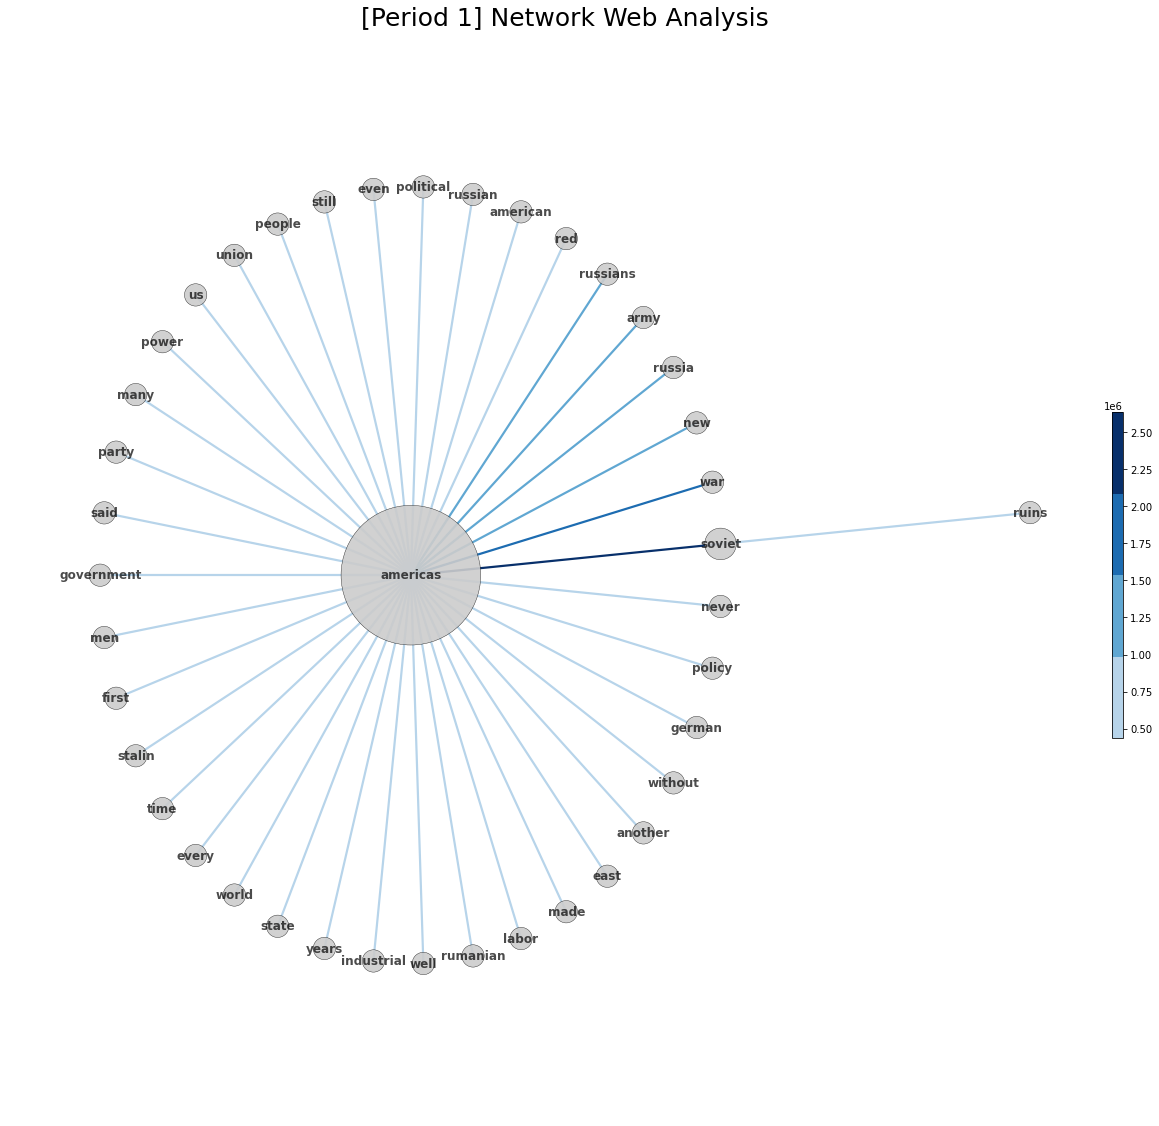

In [5]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=40, data=df)

# Network 시각화
net.plot(title='[Period 1] Network Web Analysis', root='./')

### Period 2

In [ ]:
# 최초 1회의 한하여 실행

voca = vocaDict()

result = voca.calcWordPairFreq(merge(wo_stopword_2))

voca.to_csv(root=RESULT_2)

In [6]:
df = pd.read_csv(RESULT_2+'word-pair-freq.csv')

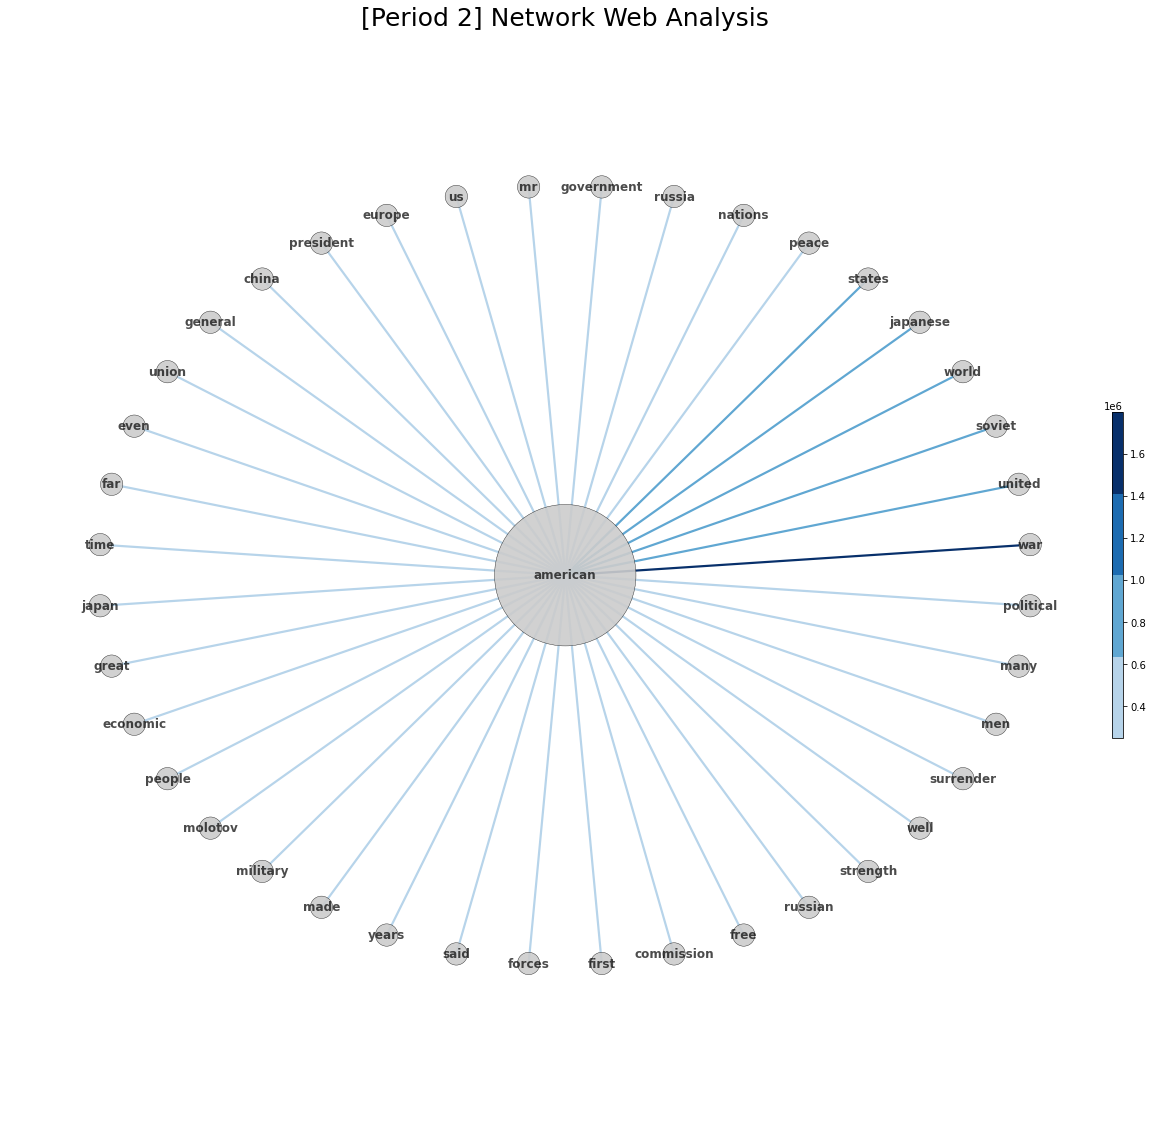

In [8]:
net = Network()

# '단어 중심성' 계산
# degree Centrality, Page Rank
net.calc_properties(edge_num=40, data=df)

# Network 시각화
net.plot(title='[Period 2] Network Web Analysis', root='./')

### Period 3

In [ ]:
# 최초 1회의 한하여 실행
voca = vocaDict()

result = voca.calcWordPairFreq(merge(wo_stopword_3))

voca.to_csv(root=RESULT_3)

In [9]:
df = pd.read_csv(RESULT_3 + 'word-pair-freq.csv')

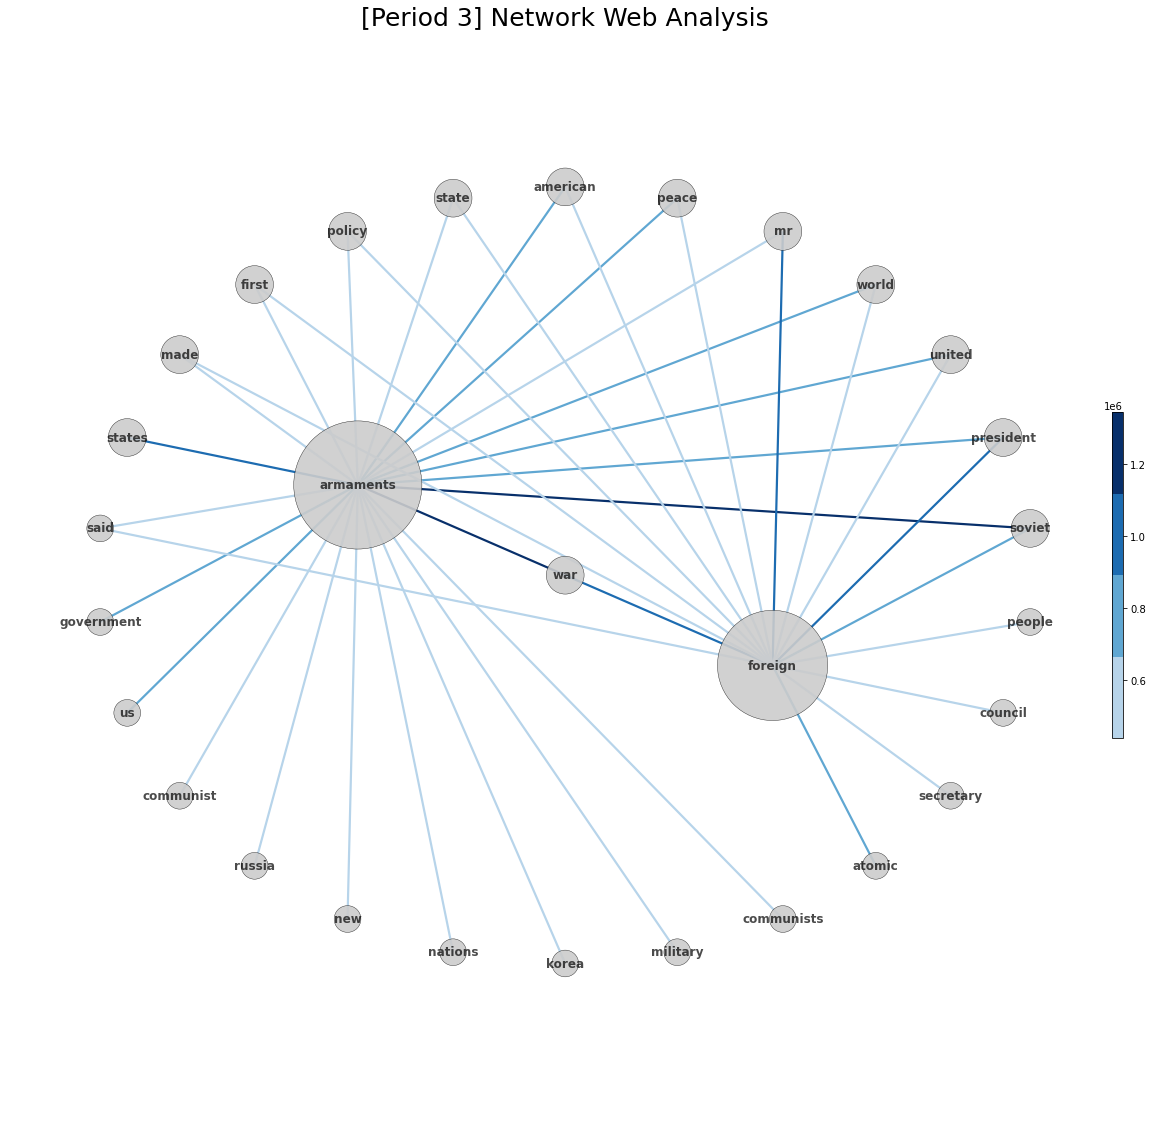

In [10]:
net = Network()

net.calc_properties(edge_num=40, data=df)

net.plot(title='[Period 3] Network Web Analysis', root='./')